In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARIMA
import math
from numpy import array

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 解决绘图中中文乱码
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['backend'] = 'SVG'

## 读取数据

In [3]:
data_path = 'E:/论文/论文2/数据/'
fig_path = 'E:/论文/论文2/论文图片/'
bt_df = pd.read_csv('E:/论文/论文2/2022_Problem_C_DATA/BCHAIN-MKPRU.csv')
gold_df = pd.read_csv('E:/论文/论文2/2022_Problem_C_DATA/LBMA-GOLD.csv')

In [4]:
bt_df.head()

,Date,Value
0,9/11/16,621.65
1,9/12/16,609.67
2,9/13/16,610.92
3,9/14/16,608.82
4,9/15/16,610.38


In [5]:
gold_df.head()

,Date,USD (PM)
0,9/12/16,1324.60
1,9/13/16,1323.65
2,9/14/16,1321.75
3,9/15/16,1310.80
4,9/16/16,1308.35


In [6]:
# 将时间转换为日期数据类型的数据
gold_df['Date']=gold_df['Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%y'))
bt_df['Date']=bt_df['Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%y'))

In [7]:
gold_df.head()

,Date,USD (PM)
0,2016-09-12,1324.60
1,2016-09-13,1323.65
2,2016-09-14,1321.75
3,2016-09-15,1310.80
4,2016-09-16,1308.35


In [8]:
gold_df.to_excel(data_path+'时间转日期黄金.xlsx',index=False)
bt_df.to_excel(data_path+'时间转日期比特币.xlsx',index=False)

将两张表进行拼接

黄金在非交易日的价格以上一个交易日的价格进行补充，并标记当前是否为黄金交易日

DealDay为1表示是黄金交易日，0为不是黄金交易日

In [9]:
df = gold_df.merge(bt_df, on='Date',how='outer')
df=df.sort_values(by='Date')
df.index=[i for i in range(df.shape[0])]
df['DealDay']=df['USD (PM)'].apply(lambda x:int(not np.isnan(x)))
df=df.fillna(method='ffill')
df.to_excel(data_path+'黄金-比特币-黄金交易日表.xlsx',index=False)
df.head()

,Date,USD (PM),Value,DealDay
0,2016-09-11,NaN,621.65,0
1,2016-09-12,1324.60,609.67,1
2,2016-09-13,1323.65,610.92,1
3,2016-09-14,1321.75,608.82,1
4,2016-09-15,1310.80,610.38,1


计算黄金与比特币的每日涨幅（未区分是否为黄金交易日）

涨幅=（今天价格-前一天价格）/前一天价格*100%

In [10]:
tmp1_gold = df['USD (PM)'].copy() # 前一天的价格
tmp2_gold = df['USD (PM)'].copy() # 当天的价格
tmp1_gold.index = tmp1_gold.index + 1
df['黄金涨幅(%)'] = 100*(tmp2_gold-tmp1_gold)/tmp1_gold

tmp1_bitcoin = df['Value'].copy() # 前一天的价格
tmp2_bitcoin = df['Value'].copy() # 当天的价格
tmp1_bitcoin.index = tmp1_bitcoin.index + 1
df['比特币涨幅(%)'] = 100*(tmp2_bitcoin-tmp1_bitcoin)/tmp1_bitcoin

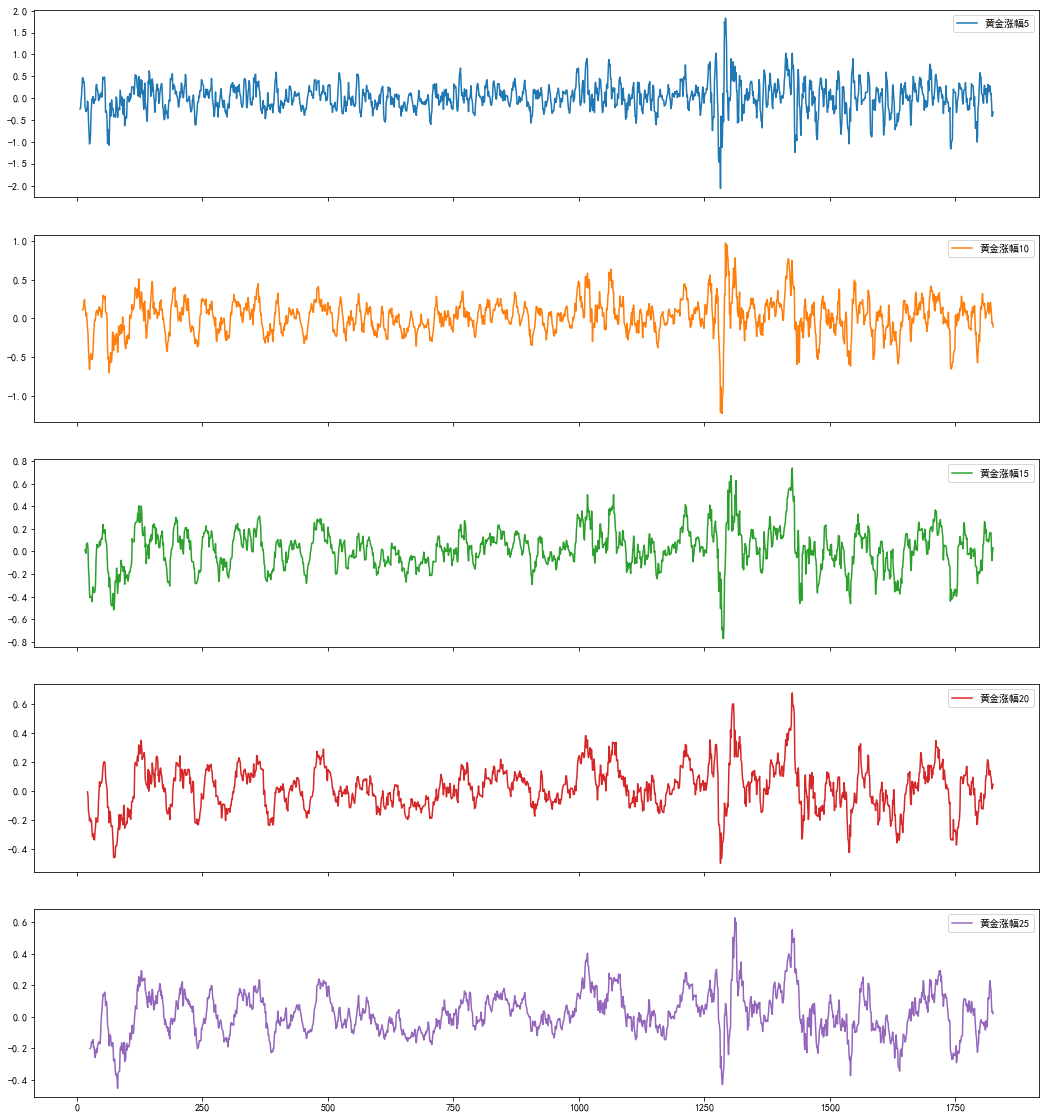

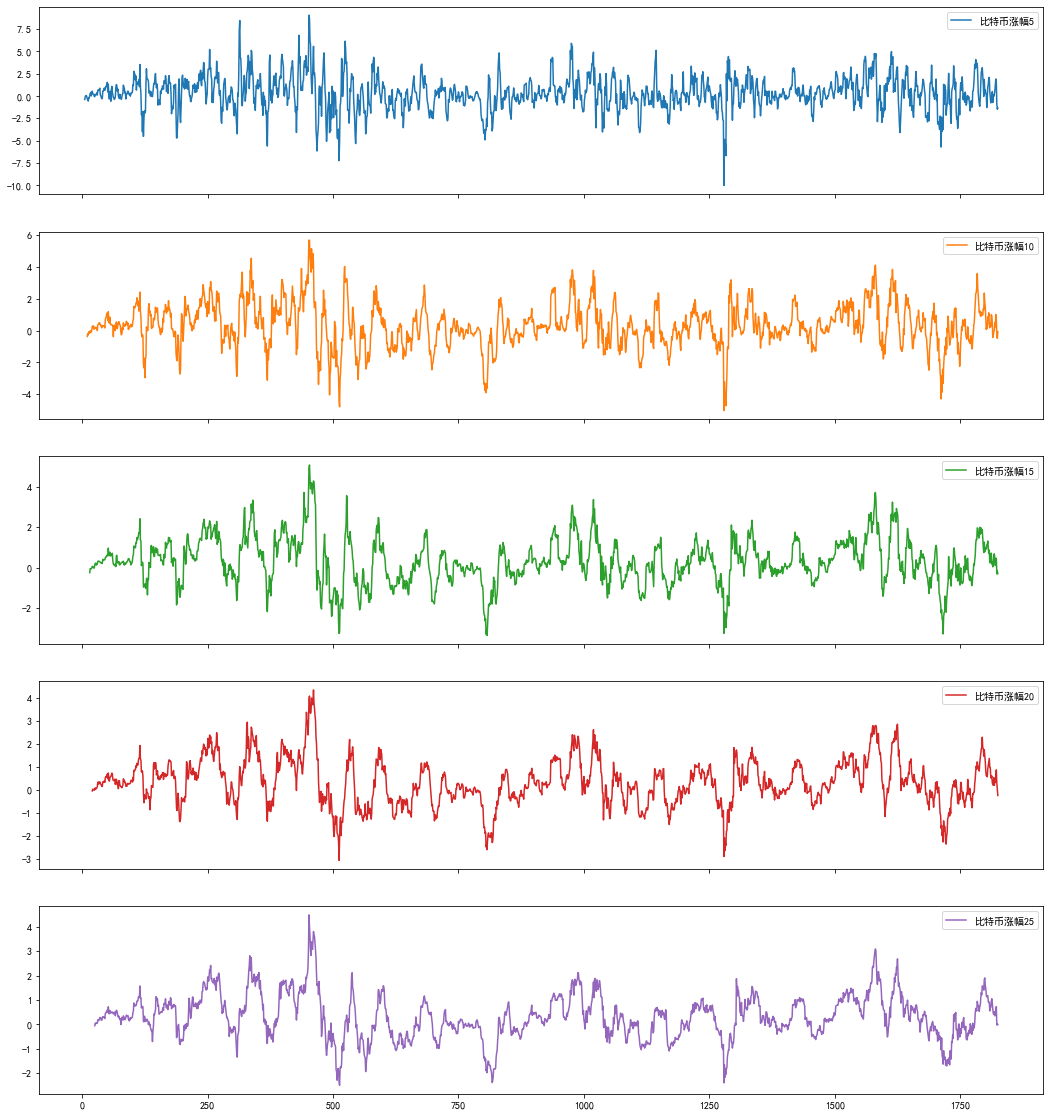

In [11]:
df_info = pd.DataFrame()
for i in range(5,26,5):
    df_info['黄金涨幅'+str(i)]=df['黄金涨幅(%)'].rolling(i).mean()
    df_info['比特币涨幅'+str(i)]=df['比特币涨幅(%)'].rolling(i).mean()
df_info[['黄金涨幅'+str(i) for i in range(5,26,5)]].plot(subplots=True, figsize=(18,20))
#plt.savefig('黄金涨幅不同时间均值对比图.png')
plt.show()
df_info[['比特币涨幅'+str(i) for i in range(5,26,5)]].plot(subplots=True, figsize=(18,20))
#plt.savefig('比特币涨幅不同时间均值对比图.png')
plt.show()

In [12]:
df_info.max()

黄金涨幅5      1.830269
比特币涨幅5     9.025968
黄金涨幅10     0.970599
比特币涨幅10    5.672694
黄金涨幅15     0.738462
比特币涨幅15    5.075998
黄金涨幅20     0.677616
比特币涨幅20    4.338736
黄金涨幅25     0.626610
比特币涨幅25    4.499509
dtype: float64

涨幅的最大值可知，根据前五天的涨幅计算的均值,约是根据前十天的涨幅均值的两倍,容易错过剧烈变化,所以根据五天的涨幅进行评估

n日乖离率=（当前价格-n日均价）/n日均价

In [13]:
rollday_gold = 5
rollday_bitcoin = 5

df['黄金5日均价']=df['USD (PM)'].rolling(rollday_gold).mean()
df['黄金5日乖离率']=100*(df['USD (PM)']-df['黄金5日均价'])/df['黄金5日均价']
df['比特币5日均价']=df['Value'].rolling(rollday_bitcoin).mean()
df['比特币5日乖离率']=100*(df['Value']-df['比特币5日均价'])/df['比特币5日均价']

In [14]:
df.to_excel('乖离率-均价表.xlsx',index=False)

In [15]:
# 先初始化，后续进行计算
df['当前黄金投资占比']=0
df['当前比特币投资占比']=0
df['黄金投资风险']=0
df['比特币投资风险']=0
df['黄金持有份额']=0
df['比特币持有份额']=0
df['现金持有份额']=0
df['总资产']=0
df['总资产变化率']=0

In [16]:
df.head(20)

,Date,USD (PM),Value,DealDay,黄金涨幅(%),比特币涨幅(%),黄金5日均价,黄金5日乖离率,比特币5日均价,比特币5日乖离率,当前黄金投资占比,当前比特币投资占比,黄金投资风险,比特币投资风险,黄金持有份额,比特币持有份额,现金持有份额,总资产,总资产变化率
0,2016-09-11,NaN,621.65,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
1,2016-09-12,1324.60,609.67,1,NaN,-1.927129,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
2,2016-09-13,1323.65,610.92,1,-0.071720,0.205029,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
3,2016-09-14,1321.75,608.82,1,-0.143542,-0.343744,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
4,2016-09-15,1310.80,610.38,1,-0.828447,0.256233,NaN,NaN,612.288,-0.311618,0,0,0,0,0,0,0,0,0
5,2016-09-16,1308.35,609.11,1,-0.186909,-0.208067,1317.83,-0.719364,609.780,-0.109876,0,0,0,0,0,0,0,0,0
6,2016-09-17,1308.35,607.04,0,0.000000,-0.339840,1314.58,-0.473916,609.254,-0.363395,0,0,0,0,0,0,0,0,0
7,2016-09-18,1308.35,611.58,0,0.000000,0.747891,1311.52,-0.241704,609.386,0.360035,0,0,0,0,0,0,0,0,0
8,2016-09-19,1314.85,610.19,1,0.496809,-0.227280,1310.14,0.359504,609.660,0.086934,0,0,0,0,0,0,0,0,0
9,2016-09-20,1313.80,608.66,1,-0.079857,-0.250742,1310.74,0.233456,609.316,-0.107662,0,0,0,0,0,0,0,0,0


In [17]:
df.columns

Index(['Date', 'USD (PM)', 'Value', 'DealDay', '黄金涨幅(%)', '比特币涨幅(%)', '黄金5日均价',
       '黄金5日乖离率', '比特币5日均价', '比特币5日乖离率', '当前黄金投资占比', '当前比特币投资占比', '黄金投资风险',
       '比特币投资风险', '黄金持有份额', '比特币持有份额', '现金持有份额', '总资产', '总资产变化率'],
      dtype='object')

对已经计算出的指标进行归一化

归一化=（当前值-最小值）/（最大值-最小值）

In [18]:
df=df.fillna(0)
for column in df.columns[4:10]:
    #print(column)
    max_,min_=df[column].max(),df[column].min()
    df[column]=df[column].apply(lambda x:(x-min_)/(max_-min_))
df.to_excel(data_path+'归一化.xlsx',index=False)
df.head()

,Date,USD (PM),Value,DealDay,黄金涨幅(%),比特币涨幅(%),黄金5日均价,黄金5日乖离率,比特币5日均价,比特币5日乖离率,当前黄金投资占比,当前比特币投资占比,黄金投资风险,比特币投资风险,黄金持有份额,比特币持有份额,现金持有份额,总资产,总资产变化率
0,2016-09-11,0.00,621.65,0,0.493311,0.641569,0.0,0.460623,0.000000,0.550392,0,0,0,0,0,0,0,0,0
1,2016-09-12,1324.60,609.67,1,0.493311,0.609981,0.0,0.460623,0.000000,0.550392,0,0,0,0,0,0,0,0,0
2,2016-09-13,1323.65,610.92,1,0.486412,0.644930,0.0,0.460623,0.000000,0.550392,0,0,0,0,0,0,0,0,0
3,2016-09-14,1321.75,608.82,1,0.479503,0.635935,0.0,0.460623,0.000000,0.550392,0,0,0,0,0,0,0,0,0
4,2016-09-15,1310.80,610.38,1,0.413621,0.645769,0.0,0.460623,0.009834,0.545356,0,0,0,0,0,0,0,0,0


## 黄金牛市

In [19]:
# 定义熵权法函数
# 输入：已经归一化的数据
def cal_weight(x):
    #x = x.apply(lambda x: ((x - np.min(x)) / (np.max(x) - np.min(x))))
    rows = x.index.size 
    cols = x.columns.size 
    k = 1.0 / math.log(rows)
    lnf = [[None] * cols for i in range(rows)]
    x = array(x)
    lnf = [[None] * cols for i in range(rows)]
    lnf = array(lnf)
    for i in range(0, rows):
        for j in range(0, cols):
            if x[i][j] == 0:
                lnfij = 0.0
            else:
                p = x[i][j] / x.sum(axis=0)[j]
                lnfij = math.log(p) * p * (-k)
            lnf[i][j] = lnfij
    lnf = pd.DataFrame(lnf)
    E = lnf

    d = 1 - E.sum(axis=0)
    w = [[None] * 1 for i in range(cols)]
    for j in range(0, cols):
        wj = d[j] / sum(d)
        w[j] = wj
    #w = pd.DataFrame(w)
    return w

In [20]:
df['黄金涨幅的前90日均值']=df['黄金涨幅(%)'].rolling(90).mean()
df['黄金5日乖离率的前90日均值'] = df['黄金5日乖离率'].rolling(90).mean()
w1 = cal_weight(df[['黄金涨幅的前90日均值','黄金5日乖离率的前90日均值']])
print(w1)

[0.5, 0.5]


牛市评估指标=w1黄金涨幅的前90日均值+w2黄金15日乖离率的前90日均值

大于牛市评估指标的均值为牛市，小于为熊市

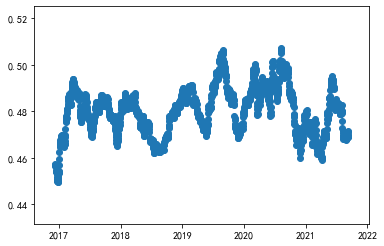

In [21]:
df['黄金牛市']=w1[0]*df['黄金涨幅的前90日均值'] + w1[1]*df['黄金5日乖离率的前90日均值']
plt.scatter(df['Date'],df['黄金牛市'])
#plt.savefig('黄金牛市指标图.png')
plt.show()

In [22]:
gold_cow = []
gold_bear = []
for i in range(15,df.shape[0]):
    if df['黄金牛市'][i]>0.48 :
        gold_cow.append(i)
    if df['黄金牛市'][i]<=0.48:
        gold_bear.append(i)

In [23]:
"""plt.plot(df['Date'][1:],df['USD (PM)'][1:])
plt.scatter(df['Date'][gold_cow].values,df['USD (PM)'][gold_cow],c='r',label='熊市')
plt.scatter(df['Date'][gold_bear].values,df['USD (PM)'][gold_bear],c='g',label='牛市')
plt.legend()
#plt.savefig('黄金牛市分布图.png')
plt.show()"""

"plt.plot(df['Date'][1:],df['USD (PM)'][1:])\nplt.scatter(df['Date'][gold_cow].values,df['USD (PM)'][gold_cow],c='r',label='熊市')\nplt.scatter(df['Date'][gold_bear].values,df['USD (PM)'][gold_bear],c='g',label='牛市')\nplt.legend()\n#plt.savefig('黄金牛市分布图.png')\nplt.show()"

根据指标使用投票法确定牛熊市时间，如：根据指标得出今天为黄金牛市，则从一个季度前开始到今天都是牛市，但是昨天计算出为熊市，且明天也计算为熊市，则可能今天计算的结果的误差较大。为解决这种误差，所有时间初始值为0，当前计算出为牛市，则前一个季度的值加1，为熊市则减一。最后的结果大于0为牛市，小于0为熊市

In [24]:
df['gold_cow']=0
for i in gold_cow:
    if i<90:
        continue
    for j in range(i-90,i):
        df['gold_cow'][j]+=1
for i in gold_bear:
    if i<90:
        continue
    for j in range(i-90,i):
        df['gold_cow'][j]-=1

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
D:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy 

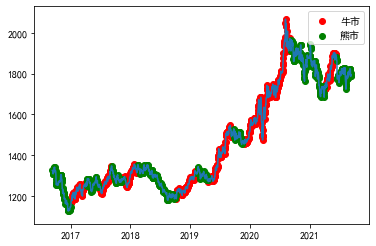

In [25]:
plt.plot(df['Date'][1:],df['USD (PM)'][1:])  # 数据的第一天不是黄金交易日，且没有数据可以补充，所以直接从第二天开始
plt.scatter(df['Date'][df['gold_cow']>0][1:],df['USD (PM)'][df['gold_cow']>0][1:],c='r',label='牛市')
plt.scatter(df['Date'][df['gold_cow']<0][1:],df['USD (PM)'][df['gold_cow']<0][1:],c='g',label='熊市')
plt.legend()
#plt.savefig('黄金牛市最终分布图.png')
plt.show()

## 比特币牛市

比特币每一个月判断一次是否为牛市

In [26]:
df['比特币涨幅的前30日均值']=df['比特币涨幅(%)'].rolling(30).mean()
df['比特币5日乖离率的前30日均值'] = df['比特币5日乖离率'].rolling(30).mean()
w2 = cal_weight(df[['比特币涨幅的前30日均值','比特币5日乖离率的前30日均值']])
print(w2)

[0.5, 0.5]


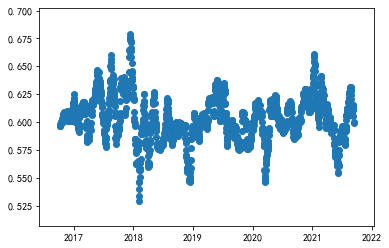

In [27]:
df['比特币牛市']=w2[0]*df['比特币涨幅的前30日均值'] + w2[1]*df['比特币5日乖离率的前30日均值']
plt.scatter(df['Date'],df['比特币牛市'])
#plt.savefig('比特币牛市指标图.png')
plt.show()

In [28]:
bt_cow = []
bt_bear = []
for i in range(15,df.shape[0]):
    if df['比特币牛市'][i]>0.6:
        bt_cow.append(i)
    if df['比特币牛市'][i]<=0.6:
        bt_bear.append(i)

In [29]:
"""plt.plot(df['Date'][1:],df['Value'][1:])
plt.scatter(df['Date'][bt_cow].values,df['Value'][bt_cow],c='r',label='牛市')
plt.scatter(df['Date'][bt_bear].values,df['Value'][bt_bear],c='g',label='熊市')
plt.legend()
#plt.savefig('比特币牛市分布图.png')
plt.show()"""

"plt.plot(df['Date'][1:],df['Value'][1:])\nplt.scatter(df['Date'][bt_cow].values,df['Value'][bt_cow],c='r',label='牛市')\nplt.scatter(df['Date'][bt_bear].values,df['Value'][bt_bear],c='g',label='熊市')\nplt.legend()\n#plt.savefig('比特币牛市分布图.png')\nplt.show()"

In [30]:
df['bt_cow']=0
for i in bt_cow:
    if i<30:
        continue
    for j in range(i-30,i):
        df['bt_cow'][j]+=1
for i in bt_bear:
    if i<30:
        continue
    for j in range(i-30,i):
        df['bt_cow'][j]-=1

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
D:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy 

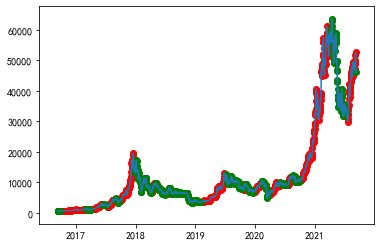

In [31]:
plt.plot(df['Date'][1:],df['Value'][1:])
plt.scatter(df['Date'][df['bt_cow']>0],df['Value'][df['bt_cow']>0],c='r')
plt.scatter(df['Date'][df['bt_cow']<0],df['Value'][df['bt_cow']<0],c='g')
#plt.savefig('比特币牛市最终分布图.png')
plt.show()

对牛市评分进行归一化

In [32]:
max_,min_=df['gold_cow'].max(),df['gold_cow'].min()
df['黄金牛市']=df['gold_cow'].apply(lambda x:(x-min_)/(max_-min_))
max_,min_=df['bt_cow'].max(),df['bt_cow'].min()
df['比特币牛市']=df['bt_cow'].apply(lambda x:(x-min_)/(max_-min_))

## 风险

黄金购买风险=w1黄金乖离率+w2黄金牛市

In [33]:
w3 = cal_weight(df[['黄金牛市','黄金5日乖离率']])
print(w3)
df['黄金购买风险']=df['黄金牛市']*w3[0]+df['黄金5日乖离率']*w3[1]

#plt.plot(df['黄金购买风险'])
#plt.savefig('黄金购买风险图.png')
#plt.show()

[0.9457017008528138, 0.054298299147186244]


In [34]:
w4 = cal_weight(df[['比特币牛市','比特币5日乖离率']])
print(w4)
df['比特币购买风险']=df['比特币牛市']*w4[0]+df['比特币5日乖离率']*w4[1]

#plt.plot(df['比特币购买风险'])
#plt.savefig('比特币购买风险图.png')
#plt.show()

[0.9748486773314305, 0.025151322668569436]


D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
D:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy 

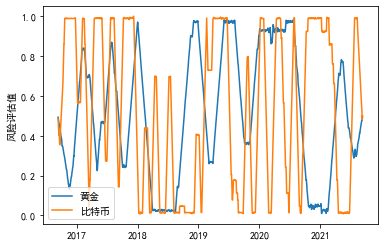

In [35]:
plt.plot(df['Date'],df['黄金购买风险'])
plt.plot(df['Date'],df['比特币购买风险'])
plt.legend(['黄金','比特币'])
plt.ylabel("风险评估值")
plt.savefig(fig_path+'图6风险评估结果.svg',format='svg')
plt.show()

In [36]:
df.to_excel(data_path+'表.xlsx',index=False)